In [4]:
# Import stuff
import numpy as np
import pandas as pd
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
from PIL import Image

/var/folders/3s/q9d61ngn2b3bm9s2ywhwmyfm0000gn/T/ipykernel_1798/203532498.py:5: DeprecationWarning: Please use `map_coordinates` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import map_coordinates
/var/folders/3s/q9d61ngn2b3bm9s2ywhwmyfm0000gn/T/ipykernel_1798/203532498.py:6: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [5]:
# Define function to draw a grid
def draw_grid(im, grid_size):
    # Draw grid lines
    for i in range(0, im.shape[1], grid_size):
        cv2.line(im, (i, 0), (i, im.shape[0]), color=(255,))
    for j in range(0, im.shape[0], grid_size):
        cv2.line(im, (0, j), (im.shape[1], j), color=(255,))

# Load images
im = cv2.imread("/Users/menelaos/Desktop/U-Nets/dataset/val_images/A172_Phase_A7_1_00d00h00m_1.png", -1)
img_mask = cv2.imread("/Users/menelaos/Desktop/U-Nets/dataset/val_masks/A172_Phase_A7_1_00d00h00m_1.png", -1)

# Draw grid lines
draw_grid(im, 50)
draw_grid(img_mask, 50)

img_mask = np.delete(img_mask, 0, 0)
img_mask = np.delete(img_mask, 0, 1)

# Merge images into separete channels (shape will be (cols, rols, 2))
im_merge = np.concatenate((im[...,None], img_mask[...,None]), axis=2)

In [6]:
# Function to distort image
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

In [7]:
def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as per [Simard2003].
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape_size = image.shape[:2]

    # Downscaling the random grid and then upsizing post filter
    # improves performance. Approx 3x for scale of 4, diminishing returns after.
    grid_scale = 4
    alpha //= grid_scale  # Does scaling these make sense? seems to provide
    sigma //= grid_scale  # more similar end result when scaling grid used.
    grid_shape = (shape_size[0]//grid_scale, shape_size[1]//grid_scale)

    blur_size = int(4 * sigma) | 1
    rand_x = cv2.GaussianBlur(
        (random_state.rand(*grid_shape) * 2 - 1).astype(np.float32),
        ksize=(blur_size, blur_size), sigmaX=sigma) * alpha
    rand_y = cv2.GaussianBlur(
        (random_state.rand(*grid_shape) * 2 - 1).astype(np.float32),
        ksize=(blur_size, blur_size), sigmaX=sigma) * alpha
    if grid_scale > 1:
        rand_x = cv2.resize(rand_x, shape_size[::-1])
        rand_y = cv2.resize(rand_y, shape_size[::-1])

    grid_x, grid_y = np.meshgrid(np.arange(shape_size[1]), np.arange(shape_size[0]))
    grid_x = (grid_x + rand_x).astype(np.float32)
    grid_y = (grid_y + rand_y).astype(np.float32)

    distorted_img = cv2.remap(image, grid_x, grid_y,
        borderMode=cv2.BORDER_REFLECT_101, interpolation=cv2.INTER_LINEAR)

    return distorted_img

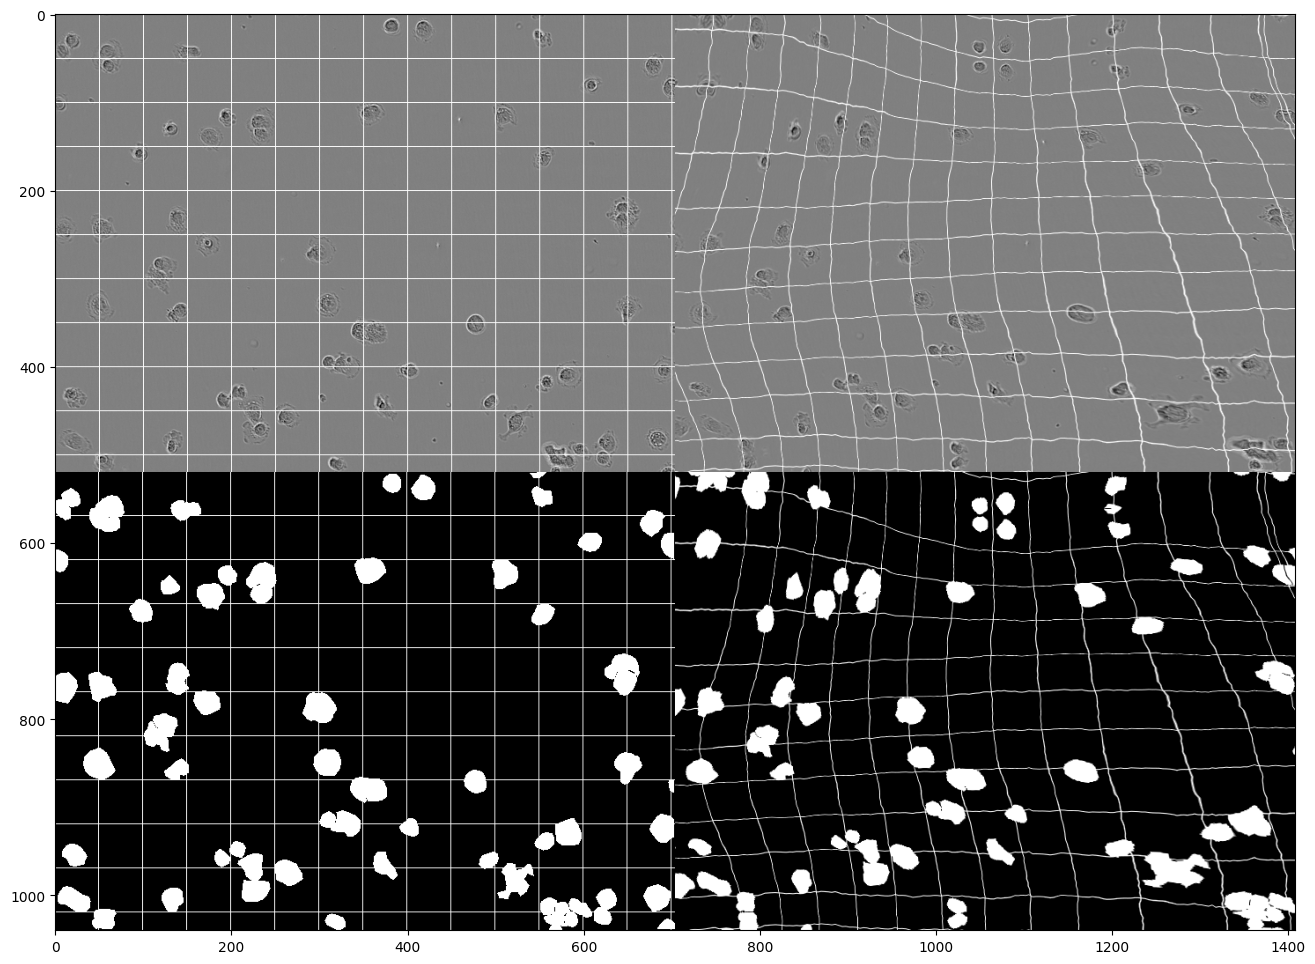

In [22]:
# First sample...

%matplotlib inline

# Apply transformation on image
im_merge_t = elastic_transform(im_merge, im_merge.shape[1] * 14, im_merge.shape[1] * 0.14)

# Split image and mask
im_t = im_merge_t[...,0]
im_mask_t = im_merge_t[...,1]

# Display result
plt.figure(figsize = (16,14))
plt.imshow(np.c_[np.r_[im, img_mask], np.r_[im_t, im_mask_t]], cmap='gray')